# NYC Taxi Fare & Duration
## Model Training

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wget
import pickle

sys.path.append("..")

import source.configs as configs
import preprocessing as preprocessing

# Check if we are in COLAB
IN_COLAB = 'google.colab' in sys.modules

In [4]:
if not os.path.exists("../dataset/yellow_tripdata_2022-05.parquet"):
    if IN_COLAB:
        !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet "../dataset"
    else:
        wget.download(configs.START_DATASET_URL, "../dataset")

In [5]:
dataset = pd.read_parquet("../dataset/yellow_tripdata_2022-05.parquet")

In [6]:
dataset = preprocessing.add_features(dataset)
dataset = preprocessing.add_targets(dataset)
dataset = preprocessing.process_outliers(dataset, "delete")
dataset = preprocessing.fill_na_values(dataset)

### Features
* trip_distance
* hour_of_day: Extracted from tpep_pickup_datetime
* hour_zone: Extracted from tpep_pickup_datetime. Categorical:[Morning, Noon, Afternoon, Evening, Night]
* rush_hour: Extracted from tpep_pickup_datetime. Binary.
### Targets
* fare_amount
* trip_duration

In [7]:
columns = preprocessing.features + preprocessing.targets
train_dataset = preprocessing.select_features(dataset, columns)
train_dataset, encoders = preprocessing.create_one_hot_encodings(train_dataset, columns)
pickle.dump(encoders, open('encoders.pkl', 'wb'))

In [8]:
train_dataset.columns.to_list()

['trip_distance',
 'rush_hour',
 'fare_amount',
 'trip_duration',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'hour_zone_afternoon',
 'hour_zone_evening',
 'hour_zone_morning',
 'hour_zone_night',
 'hour_zone_noon']

In [9]:
for col in train_dataset.isna().sum():
    assert col==0
print("Ok, no NAs in train dataset.")

Ok, no NAs in train dataset.


In [10]:
train_dataset.describe()

,trip_distance,rush_hour,fare_amount,trip_duration,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,hour_zone_afternoon,hour_zone_evening,hour_zone_morning,hour_zone_night,hour_zone_noon
count,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06,2.976593e+06
mean,3.514028e+00,3.146419e-01,1.445461e+01,1.625068e+01,1.317970e-01,1.434214e-01,1.480747e-01,1.516029e-01,1.431217e-01,1.361469e-01,1.458355e-01,3.036475e-01,2.434874e-01,2.287918e-01,1.673118e-01,5.676154e-02
std,4.241348e+00,4.643732e-01,1.186018e+01,1.270762e+01,3.382700e-01,3.505021e-01,3.551740e-01,3.586356e-01,3.501970e-01,3.429446e-01,3.529413e-01,4.598323e-01,4.291869e-01,4.200549e-01,3.732540e-01,2.313864e-01
min,1.000000e-01,0.000000e+00,2.500000e+00,2.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.170000e+00,0.000000e+00,7.000000e+00,7.800000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.920000e+00,0.000000e+00,1.050000e+01,1.268333e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.600000e+00,1.000000e+00,1.600000e+01,2.038333e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.500000e+01,1.000000e+00,7.500000e+01,9.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [30]:
train_dataset.columns.to_list()

['trip_distance',
 'rush_hour',
 'fare_amount',
 'trip_duration',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'hour_zone_afternoon',
 'hour_zone_evening',
 'hour_zone_morning',
 'hour_zone_night',
 'hour_zone_noon']

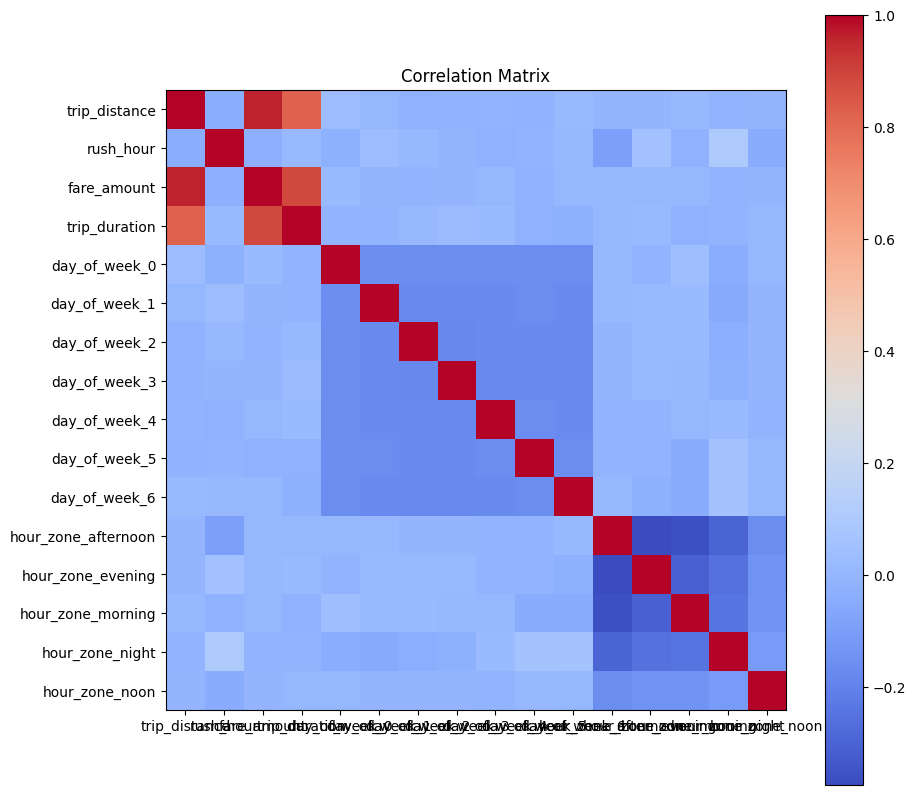

In [11]:
correlation_matrix = train_dataset.corr()
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Correlation Matrix')
plt.xticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns)
plt.yticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns)
plt.show()

## Model Training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# models: random_forest, linear, nn, gbm
model = "gbm"

Split dataset

In [14]:
# Split features and targets
X, y = preprocessing.split_dataset(train_dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_td = y_train["trip_duration"]
y_train_fa = y_train["fare_amount"]

Model preparation

In [33]:
if model == "nn":
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.wrappers.scikit_learn import KerasRegressor
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    def baseline_model():
        # create model
        model = Sequential()
        model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
else:
    scaler = None
    X_train_scaled = X_train
    X_test_scaled = X_test

In [34]:
if model == "random_forest":
    from sklearn.ensemble import RandomForestRegressor
    model_td = RandomForestRegressor(n_jobs=-1, n_estimators=5)
    model_fa = RandomForestRegressor(n_jobs=-1, n_estimators=5)
elif model == "linear":
    from sklearn.linear_model import LinearRegression
    model_td = LinearRegression(n_jobs=-1)
    model_fa = LinearRegression(n_jobs=-1)
elif model == "gbm":
    print("Model LightGBM")
    import lightgbm as lgb
    train_data_lgb_td = lgb.Dataset(X_train_scaled, label=y_train_td)
    train_data_lgb_fa = lgb.Dataset(X_train_scaled, label=y_train_fa)
    params = {
    'objective': 'regression',  # 'regression' for regression problems
    'metric': 'rmse',          # Root Mean Squared Error for evaluation
    'boosting_type': 'gbdt',   # Gradient Boosting Decision Tree
    'num_leaves': 100,          # Maximum number of leaves in one tree
    'learning_rate': 0.05,     # Learning rate
    'feature_fraction': 0.9,   # Fraction of features to be used in each iteration
    'bagging_fraction': 0.8,   # Fraction of data to be used for bagging
    'bagging_freq': 5,         # Frequency for bagging
    'verbose': 1               # Verbosity (0: silent, 1: progress bar, 2: print all)
    }
    num_rounds = 100  # Number of boosting rounds (iterations)
elif model == "nn":
    seed = 7
    np.random.seed(seed)
    estimator_td = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)
    estimator_fa = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)
    kfold = KFold(n_splits=10, random_state=seed)    

Model LightGBM


Model training

In [17]:
if model in ["linear", "random_forest"]:
    print("Fit model TD")
    model_td.fit(X_train_scaled, y_train_td.values.ravel());
    print("Fit model FA")
    model_fa.fit(X_train_scaled, y_train_fa.values.ravel());
elif model == "gbm":
    print("Training LGBM")
    print("Fit model TD")
    model_td = lgb.train(params, train_data_lgb_td, num_rounds)
    print("Fit model FA")
    model_fa = lgb.train(params, train_data_lgb_fa, num_rounds)
    print("Done!")
elif model == "nn":
    print("Training Neural Network")
    print("Fit model TD")
    results_td = cross_val_score(estimator_td, X_train_scaled.values, y_train_td.values, cv=kfold, n_jobs=1)
    print("Fit model FA")
    results_fa = cross_val_score(estimator_fa, X_train_scaled.values, y_train_fa.values, cv=kfold, n_jobs=1)
    print("Done!")

Training LGBM
Fit model TD
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 2381274, number of used features: 14
[LightGBM] [Info] Start training from score 16.255198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [18]:
test_predictions_fa = model_fa.predict(X_test_scaled)
test_predictions_td = model_td.predict(X_test_scaled)

y_test_td = y_test["trip_duration"]
mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
r2_td = r2_score(y_test_td, test_predictions_td)
print(f"Trip duration MSE: {mse_td} minutes")
print(f"Trip duration R2: {r2_td}")

y_test_fa = y_test["fare_amount"]
mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
r2_fa = r2_score(y_test_fa, test_predictions_fa)
print(f"Fare amount MSE: {mse_fa} $")
print(f"Fare amount R2: {r2_fa}")


Trip duration MSE: 6.425813941542135 minutes
Trip duration R2: 0.7437561746117429
Fare amount MSE: 3.070061710687206 $
Fare amount R2: 0.9328547119881709


In [19]:
pickle.dump(model_fa, open('model_fa.pkl', 'wb'))
pickle.dump(model_td, open('model_td.pkl', 'wb'))
if scaler:
    pickle.dump(scaler, open('scaler.pkl', 'wb'))

### Inference

In [20]:
if os.path.exists("model_td.pkl"):
    with open("model_td.pkl", "rb") as model_td_file:
        model_td = pickle.load(model_td_file)
else:
    print("TD model not found!")

if os.path.exists("model_fa.pkl"):
    with open("model_fa.pkl", "rb") as model_fa_file:
        model_fa = pickle.load(model_fa_file)
else:
    print("FA model not found!")

if os.path.exists("scaler.pkl"):
    with open("scaler.pkl", "rb") as scaler_file:
        scaler = pickle.load(scaler_file)
else:
    print("Scaler model not found!")

if os.path.exists("encoders.pkl"):
    with open("encoders.pkl", "rb") as encoders_file:
        encoders = pickle.load(encoders_file)
else:
    print("Encoders model not found!")

Input

In [21]:
pickup_date="2023/12/12"
pickup_time="12:15:12"
tpep_pickup_datetime = pickup_date + " " + pickup_time
trip_distance = "5.5"

In [22]:
data = {
    "trip_distance": [float(trip_distance)], 
    "tpep_pickup_datetime": [pd.to_datetime(tpep_pickup_datetime)] }
df = pd.DataFrame(data)
df = preprocessing.add_features(df)
df.drop(columns="tpep_pickup_datetime", inplace=True)

In [23]:
for encoder_model in encoders:
    encoder, col = encoder_model
    array = pd.DataFrame(df[col].values.reshape(1,-1), columns=[col])
    encoded_data = encoder.transform(array)
    encoded_data = encoded_data.toarray()
    encoded_df = pd.DataFrame(encoded_data, 
                            columns=encoder.get_feature_names_out([col])
    )
    df = pd.concat([df, encoded_df], axis=1, join="inner")
    df.drop(columns=col, inplace=True)

In [24]:
if model == "nn":
    df = scaler.transform(df)

In [29]:
df.columns.to_list()

['trip_distance',
 'hour_of_day',
 'rush_hour',
 'day_of_week_0',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'hour_zone_afternoon',
 'hour_zone_evening',
 'hour_zone_morning',
 'hour_zone_night',
 'hour_zone_noon']

In [35]:
if model == "lightgbm":
    df = lgb.Dataset(df)
y_fa = round(model_fa.predict(df)[0],2)
y_td = int(model_td.predict(df)[0])

[LightGBM] [Fatal] The number of features in data (15) is not the same as it was in training data (14).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (15) is not the same as it was in training data (14).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
print(f"Trip duration: {y_td} minutes")
print(f"Fare amount: $ {y_fa}")